In [ ]:
import io
import itertools
from collections.abc import Iterable, Iterator, Sequence
from dataclasses import dataclass
from enum import Enum, unique
from pathlib import PurePosixPath

import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import radtran
import tqdm
import xarray as xr
from azure.ai.ml import MLClient
from satellite_data_product.sentinel2_legacy.stages.sim_creation.sim_creation_utils import (
    randomly_position_sim_plume,
)
from xarray_einstats.stats import logsumexp

from src.azure_wrap.ml_client_utils import (
    get_abfs_output_directory,
    get_storage_options,
    initialize_ml_client,
)
from src.validation.detection_probability import (
    crop_enhancements,
    load_gorrono_plumes,
)

In [2]:
import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("azure")
logger.setLevel(logging.ERROR)

ml_client = initialize_ml_client()

Found the config file in: /config.json


## Step 1: Download a given EMIT tile

**NOTE: There would be a precursor step to this, one that would be a one off separate script:**
- A one off separate script that queries the EMIT STAC catalog to find available scenes over No Methane areas

In [3]:
# Note: lets assume we have a csv with our chosen EMIT tile ids (eq to a MGRS-date pair).
# With this, we will just use the STAC catalog to get the OBS and RAD NetCDF files to
# download the data. Since we are just using one snapshot (t), we do not need to query the
# STAC catalog to figure out what snapshots are available for the given EMIT data take. In
# other words we do not need functionality like `choose_sentinel2_snapshots`.


@dataclass
class EmitTileUris:
    """
    Handles URI construction for EMIT data products.

    Attributes:
        tile_id: The EMIT tile identifier (e.g., 'EMIT_L1B_RAD_001_20240127T195840_2402713_006')
        sensor: Always "EMIT"
        product_level: L1B or L2A
        product_type: RAD, OBS, etc.
        version: The product version (e.g., '001')
        acquisition_date: The acquisition date (YYYYMMDD)
        acquisition_time: The acquisition time (HHMMSS)
        orbit_id: The orbit identifier
        scene_id: The scene identifier
    """

    tile_id: str
    sensor: str
    product_level: str
    product_type: str
    version: str
    acquisition_date: str
    acquisition_time: str
    orbit_id: str
    scene_id: str

    @classmethod
    def from_tile_id(cls, tile_id: str) -> "EmitTileUris":
        """Create an EmitTileUris instance by parsing a tile ID."""
        components = cls.parse_emit_id(tile_id)
        return cls(
            tile_id=tile_id,
            sensor=components["sensor"],
            product_level=components["product_level"],
            product_type=components["product_type"],
            version=components["version"],
            acquisition_date=components["acquisition_date"],
            acquisition_time=components["acquisition_time"],
            orbit_id=components["orbit_id"],
            scene_id=components["scene_id"],
        )

    @staticmethod
    def parse_emit_id(emit_id: str) -> dict:
        """
        Parse an EMIT Level 1 or Level 2A filename and extract its components.

        Following naming conventions here: https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/emit-overview/#emit-naming-conventions

        Example filename/id: EMIT_L1B_RAD_001_20240127T195840_2402713_006

        """
        pattern = (
            r"EMIT_(L[12][A-Z])_([A-Z]+)_(\d{3})_"  # Product Level, Type, Version
            r"(\d{8})T(\d{6})_"  # Acquisition Date and Time
            r"(\d{7})_(\d{3})"  # Orbit ID, Scene ID
        )

        match = re.match(pattern, emit_id)
        if not match:
            raise ValueError("Invalid EMIT ID format")

        return {
            "sensor": "EMIT",
            "product_level": match.group(1),
            "product_type": match.group(2),
            "version": match.group(3),
            "acquisition_date": match.group(4),  # Keep as YYYYMMDD
            "acquisition_time": match.group(5),  # Keep as HHMMSS
            "orbit_id": match.group(6),
            "scene_id": match.group(7),
        }

    @property
    def datetime_str(self) -> str:
        """Get the datetime string used in URIs."""
        return f"{self.acquisition_date}T{self.acquisition_time}"

    @property
    def uris(self) -> dict[str, str]:
        """Get the URIs for this tile's data products."""
        base_url = "https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected"

        # Build file identifiers
        rad_id = f"EMIT_L1B_RAD_{self.version}_{self.datetime_str}_{self.orbit_id}_{self.scene_id}"
        obs_id = f"EMIT_L1B_OBS_{self.version}_{self.datetime_str}_{self.orbit_id}_{self.scene_id}"
        l2_rfl_id = f"EMIT_L2A_RFL_{self.version}_{self.datetime_str}_{self.orbit_id}_{self.scene_id}"
        mask_id = f"EMIT_L2A_MASK_{self.version}_{self.datetime_str}_{self.orbit_id}_{self.scene_id}"

        return {
            "rad": f"{base_url}/EMITL1BRAD.001/{rad_id}/{rad_id}.nc",
            "obs": f"{base_url}/EMITL1BRAD.001/{rad_id}/{obs_id}.nc",
            "mask": f"{base_url}/EMITL2ARFL.001/{l2_rfl_id}/{mask_id}.nc",
        }


# NOTE: in our code base we will use the EMIT filename as its tile id
def download_emit_data(tile_id: str) -> dict[str, xr.Dataset]:
    """
    Download EMIT data for a given tile ID by determinisitcally building the relevant URIs

    Args:
        tile_id: The EMIT tile identifier (e.g., 'EMIT_L1B_RAD_001_20240127T195840_2402713_006')

    Returns:
        Tuple of local Paths to the downloaded RAD, OBS, and QA MASK files
    """
    tile = EmitTileUris.from_tile_id(tile_id)
    uris = tile.uris
    print(uris)

    # Download and open datasets directly in memory
    earthaccess.login(persist=True)
    earthaccess_session = earthaccess.get_requests_https_session()

    rad_response = earthaccess_session.get(uris["rad"])
    obs_response = earthaccess_session.get(uris["obs"])
    mask_response = earthaccess_session.get(uris["mask"])

    rad_ds = xr.open_dataset(io.BytesIO(rad_response.content))
    obs_ds = xr.open_dataset(io.BytesIO(obs_response.content))
    mask_ds = xr.open_dataset(io.BytesIO(mask_response.content))

    return {"rad_ds": rad_ds, "obs_ds": obs_ds, "mask_ds": mask_ds}

In [4]:
EmitTileUris.from_tile_id("EMIT_L1B_RAD_001_20240127T195840_2402713_006")

EmitTileUris(tile_id='EMIT_L1B_RAD_001_20240127T195840_2402713_006', sensor='EMIT', product_level='L1B', product_type='RAD', version='001', acquisition_date='20240127', acquisition_time='195840', orbit_id='2402713', scene_id='006')

In [5]:
%%time
emit_tile_id = "EMIT_L1B_RAD_001_20240127T195840_2402713_006"
emit_data = download_emit_data(emit_tile_id)
emit_data["rad_ds"]

{'rad': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20240127T195840_2402713_006/EMIT_L1B_RAD_001_20240127T195840_2402713_006.nc', 'obs': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20240127T195840_2402713_006/EMIT_L1B_OBS_001_20240127T195840_2402713_006.nc', 'mask': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240127T195840_2402713_006/EMIT_L2A_MASK_001_20240127T195840_2402713_006.nc'}
CPU times: user 4.73 s, sys: 3.06 s, total: 7.79 s
Wall time: 1min 25s


<xarray.Dataset> Size: 2GB
Dimensions:            (downtrack: 1280, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    radiance           (downtrack, crosstrack, bands) float32 2GB ...
    flat_field_update  (crosstrack, bands) float32 1MB ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             29.831140580306617
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.03757011e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L1B At-Sensor Calibrated Radiance...

##### Sanity Check: L1 and L2 data is for same scene

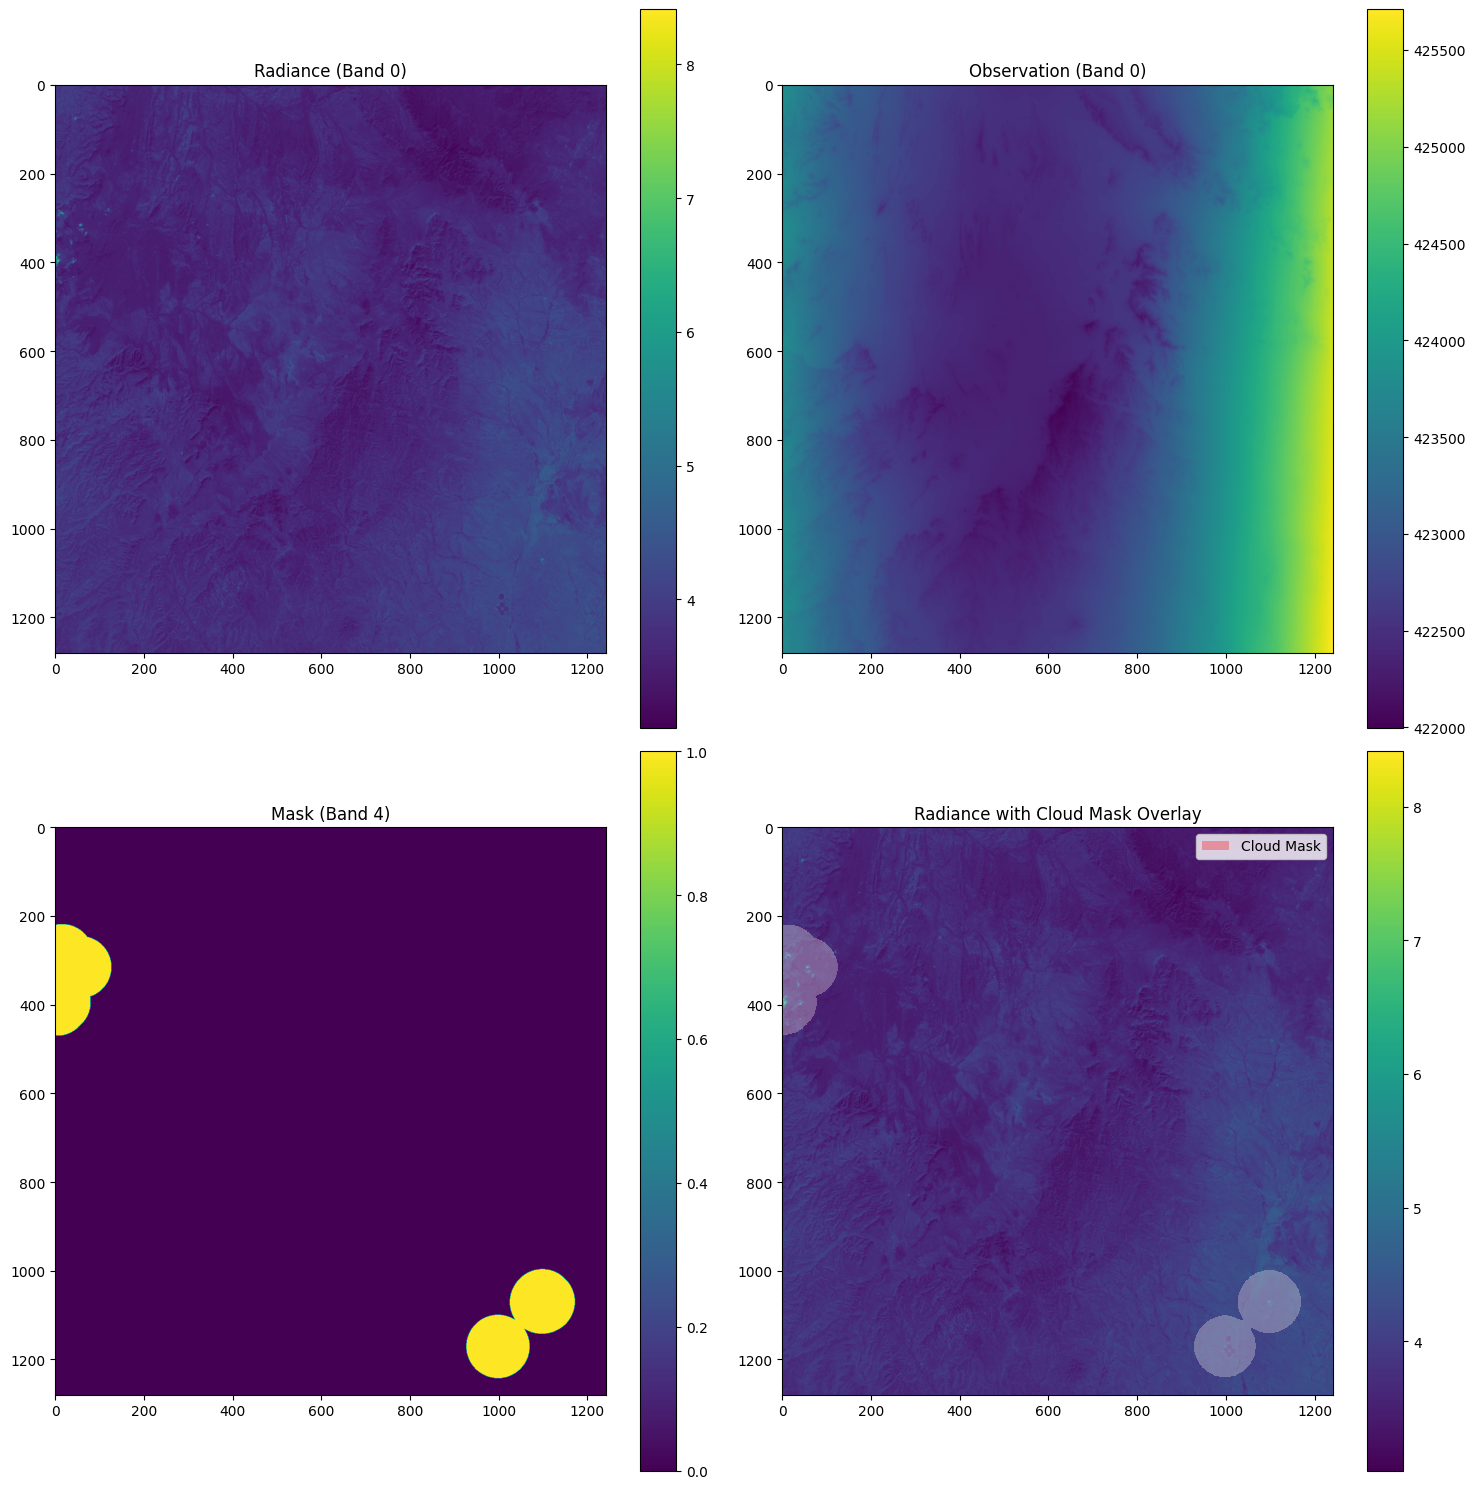

In [6]:
band_idx = 0

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot radiance
rad_img = emit_data["rad_ds"].radiance.isel(bands=band_idx)
im1 = axes[0, 0].imshow(rad_img, cmap="viridis")
axes[0, 0].set_title(f"Radiance (Band {band_idx})")
plt.colorbar(im1, ax=axes[0, 0])

# Plot observation
obs_img = emit_data["obs_ds"].obs.isel(bands=band_idx)
im2 = axes[0, 1].imshow(obs_img, cmap="viridis")
axes[0, 1].set_title(f"Observation (Band {band_idx})")
plt.colorbar(im2, ax=axes[0, 1])

# Plot mask
mask_img = emit_data["mask_ds"].mask.isel(bands=4)
im3 = axes[1, 0].imshow(mask_img, cmap="viridis")
axes[1, 0].set_title("Mask (Band 4)")
plt.colorbar(im3, ax=axes[1, 0])

# Plot radiance with cloud mask overlay
label_values = [0, 1, 4]
cloud_mask = (emit_data["mask_ds"].mask[..., label_values] > 0).any(dim="bands")

# Plot radiance data
im4 = axes[1, 1].imshow(rad_img, cmap="viridis")

# Overlay cloud mask in red with transparency
cloud_overlay = np.ma.masked_where(~cloud_mask, np.ones_like(cloud_mask))
axes[1, 1].imshow(cloud_overlay, cmap="Reds", alpha=0.3)

axes[1, 1].set_title("Radiance with Cloud Mask Overlay")
plt.colorbar(im4, ax=axes[1, 1])

# Add labels for mask types in legend
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor="red", alpha=0.3, label="Cloud Mask")]
axes[1, 1].legend(handles=legend_elements, loc="upper right")

plt.tight_layout()

**Is there any overlapping logic with the S2 code `generate.py` wrt to downloading the data?**
- Not really
- Downloading logic for S2 is covered by `choose_sentinel2_snapshots`
    - For a given MGRS-date, this function queries the L2A pystac catalog within a date range to find all available scenes
        - potentially `search_by_tile_id` can be refactored as a common function between EMIT and S2
    - It uses the SCL cloud mask to filter for valid scenes
    - Returns the t-2, t-1, t, t+1 scenes. Wraps the pystac items in our custom Sentinel2Item class, which has convenience methods to access metadata attributes (i.e obs angle), retrieve band filepaths, and crop bands
- For EMIT we cannot really build a time series, so there is no need to search the STAC catalog
- The approach for EMIT is simplified: download the relevant netcdf files for the main snapshot so it can be used for further processing
    - Note: this data is written to disk, so will take space. Not a huge issue— we will just need to download data for one scene per run

**Questions:**
- Would we want to upload the EMIT raw data to Azure?
    - I dont see the value of this
- Is there need for an EMIT download data manager class, i.e something like what we do for S2: `Sentinel2Item`?
    - I also don't see purpose of this. Either way we will have to download the files
 
**Implementation Notes:**
- We assume we have a CSV with the EMIT tiles pre specified, similar to what we do for S2: `src/data/recycled_plumes/no_methane_tiles/csv_files/MGRS_near_OG_selection_1200.csv`
- To create that CSV, I imagine it would be a one-off separate script where we query the EMIT STAC catalog over No Methane regions, following the points Maxime made here https://git.orbio.earth/orbio/orbio/-/issues/868#note_72011

## Step 2: Crop the EMIT data

In [6]:
height, width = emit_data["rad_ds"].radiance.shape[0:2]
n_crops_h = height // 128
n_crops_w = width // 128
height, width, n_crops_h, n_crops_w

(1280, 1242, 10, 9)

We would get 90 128x128 crops for an EMIT tile.

In [7]:
@unique
class EMITL2AMaskLabel(Enum):
    """
    Labels in the EMIT L2A Mask file.

    Source: https://lpdaac.usgs.gov/products/emitl2arflv001/
    """

    CLOUD = 0
    CIRRUS_CLOUD = 1
    WATER = 2
    SPACECRAFT = 3  # what is this haha
    DILATED_CLOUD = 4
    AEROSOL = 5  # AOD550 (Aerosol Optical Depth), NOTE: not a boolean flag
    WATER_VAPOR = 6  # (in g/cm2), NOTE: not a boolean flag
    AGGREGATE = 7  # composite mask - all flags combined


def crop_emit_data(
    emit_data: dict[str, xr.Dataset],
    emit_mask_labels: list[EMITL2AMaskLabel],
    main_crop_cloud_coverage_threshold_range: tuple[float, float],
    crop_size: int,
) -> Iterator[dict]:
    """Crops EMIT RAD and OBS data into smaller patches."""
    rad_ds = emit_data["rad_ds"]
    obs_ds = emit_data["obs_ds"]
    mask_ds = emit_data["mask_ds"].mask

    shapes = {
        "radiance": rad_ds.radiance.shape[:2],
        "observation": obs_ds.obs.shape[:2],  # adjust variable name if needed
        "mask": mask_ds.shape[:2],
    }
    assert len(set(shapes.values())) == 1, f"Dataset shapes don't match: {shapes}"

    label_values = [label.value for label in emit_mask_labels]

    # Get dimensions
    height, width = rad_ds.radiance.shape[0:2]

    for i, j in itertools.product(range(height // crop_size), range(width // crop_size)):
        # Calculate crop coordinates
        h_start = i * crop_size
        h_end = h_start + crop_size
        w_start = j * crop_size
        w_end = w_start + crop_size

        # Extract crops
        rad_crop = rad_ds.isel(downtrack=slice(h_start, h_end), crosstrack=slice(w_start, w_end))
        obs_crop = obs_ds.isel(downtrack=slice(h_start, h_end), crosstrack=slice(w_start, w_end))
        mask_crop = mask_ds.isel(downtrack=slice(h_start, h_end), crosstrack=slice(w_start, w_end))

        # Filter for valid crops
        mean_mask = float((mask_crop[..., label_values] == 1).any(dim="bands").mean())
        lower_limit, upper_limit = main_crop_cloud_coverage_threshold_range
        if not (lower_limit <= mean_mask < upper_limit):
            continue

        # TODO: think about whether it is better to return a data class instead
        yield {
            "rad_crop": rad_crop,
            "obs_crop": obs_crop,
            "mask_crop": mask_crop,
            "crop_x": w_start,
            "crop_y": h_start,
            "cloud_ratio": mean_mask,
        }

In [8]:
emit_mask_labels = [
    EMITL2AMaskLabel.CLOUD,
    EMITL2AMaskLabel.CIRRUS_CLOUD,
    EMITL2AMaskLabel.DILATED_CLOUD,
]
main_crop_cloud_coverage_threshold_range = (0, 0.3)  # max 30%
crop_generator = crop_emit_data(emit_data, emit_mask_labels, main_crop_cloud_coverage_threshold_range, crop_size=128)

**Is there any overlapping logic with the S2 code `generate.py` wrt to cropping the data?**
- No, for EMIT we would use this fn separately
- FYI: S2 cropping is done in `generate_all_data_items_from_tile()`

**Implementation Notes:**
- Cropping/all data generation processing is done in memory

## Step 3: Insert simulated plumes into EMIT Crops

- Using `EMIT-Radtran.ipynb` POC

In [9]:
m2_to_cm2 = radtran.utils.constants.m2_to_cm2  # Units: cm2/m2
mol_to_N = radtran.utils.constants.mol_to_N  # Units: #/mol


def precompute_log_norm_brightness(
    sensor_band_parameters: xr.DataArray,
    CH4_absorption: xr.DataArray,
    gamma_concentration: Sequence[float],
) -> xr.DataArray:
    """
    Precompute logarithmic normalized brightness values for methane absorption,
    using the Beer-Lambert law.

    Parameters
    ----------
    sensor_band_parameters : xr.DataArray
        Sensor specifications including:
        - 'fwhm': Full Width at Half Maximum for each band
        - 'wavelengths': Central wavelength for each band
    CH4_absorption : xr.DataArray
        Methane absorption cross-sections with wavelength coordinates
        in the same units as used in sensor_band_parameters.
        Units: cm/#
    gamma_concentration : Sequence[float]
        Sequence of concentration values to compute absorption for.
        Units: mol/m2

    Returns
    -------
    xr.DataArray
        Logarithmic normalized brightness values for each band and concentration.
        Dimensions: (gamma_concentration, bands)

    Notes
    -----
    The calculation uses the following steps:
    1. Creates Gaussian SRF using sensor parameters
    2. Applies Beer-Lambert law with numerical stability using logsumexp
    3. Normalizes by the sum of the spectral response function

    The final result represents log(I/I₀) where:
    - I is the intensity after absorption
    - I₀ is the initial intensity

    Uses mol_to_N and m2_to_cm2 constants imported from external module.
    """
    # Create wavelength DataArray
    wavelength_da = CH4_absorption.wavelength

    # Calculate Gaussian spectral response function parameters
    sigma2 = sensor_band_parameters["fwhm"] ** 2 / (8 * np.log(2))
    all_bands_gaussian_srf = np.exp(-((wavelength_da - sensor_band_parameters["wavelengths"]) ** 2) / (2 * sigma2))

    # Create gamma concentration dimension
    gamma_concentration = pd.Index(gamma_concentration, name="gamma_concentration")

    # Implement the Beer-Lambert law in a numerically stable manner
    lse = [
        logsumexp(-gc * mol_to_N / m2_to_cm2 * CH4_absorption, dims=["wavelength"], b=all_bands_gaussian_srf)
        for gc in tqdm.tqdm(gamma_concentration)
    ]
    lse = xr.concat(lse, dim=gamma_concentration)

    # Normalize by spectral response function
    logdenom = np.log(all_bands_gaussian_srf.sum(dim="wavelength"))
    log_normalized_brightness = lse - logdenom

    return log_normalized_brightness


def interpolate_normalized_brightness(
    gamma_concentration: np.ndarray,
    log_nB_table_for_band: xr.DataArray,
) -> np.ndarray:
    """
    Interpolate normalized brightness values for methane pixels using a lookup table.

    Parameters
    ----------
    gamma_concentration : np.ndarray
        Array of gamma * concentration values for pixels with methane present,
        where concentration is in mol/m².
    log_nB_table_for_band : xr.DataArray
        Log-normalized brightness values indexed by gamma_concentration for a specific band.

    Returns
    -------
    np.ndarray
        Interpolated normalized brightness values for the input pixels.
    """
    absorption = -np.expm1(log_nB_table_for_band)
    return -np.expm1(
        np.interp(
            np.log(gamma_concentration),
            np.log(absorption.gamma_concentration),
            np.log(absorption),
        )
    )


def compute_normalized_brightness(
    gamma: xr.DataArray,
    concentration: xr.DataArray,
    log_nB_table: xr.DataArray,
) -> xr.DataArray:
    """
    Interpolate normalized brightness values for each band based on methane concentration.

    For pixels containing methane (where gamma * concentration > minimum threshold),
    this function interpolates band-specific normalized brightness values using a
    pre-computed lookup table. For all other pixels, the normalized brightness is 1.0
    (indicating no absorption).

    Bands with negligible methane absorption (maximum absorption < 1e-5) are skipped
    and their normalized brightness values remain at 1.0.

    Parameters
    ----------
    gamma: xr.DataArray
        The gamma value for each pixel. Gamma is the path length multiplier
        for light traveling through the atmosphere, calculated as:
        1/cos(theta_sun) + 1/cos(theta_sensor)
        where theta_sun is the solar zenith angle
        and theta_sensor is the sensor zenith angle.
    concentration : xr.DataArray
        Methane concentration values in mol/m². Must have same spatial dimensions
        as gamma. Values > 0 indicate presence of methane.
    log_nB_table : xr.DataArray
        Pre-computed lookup table of log-normalized brightness values. Has dimensions
        'bands' and 'gamma_concentration', where gamma_concentration is the product
        of gamma and methane concentration in mol/m².

    Returns
    -------
    xr.DataArray
        The normalized brightness values for each band and pixel. Has the same spatial
        dimensions as the input arrays plus a 'bands' dimension. Values are between
        0 and 1, where:
        - 1.0 indicates no absorption (either no methane or band insensitive to methane)
        - < 1.0 indicates absorption, with smaller values meaning stronger absorption
    """
    # Identify pixels with methane
    gamma_concentration = gamma * concentration
    lower_threshold = log_nB_table.gamma_concentration.min().item()
    methane_pixels = gamma_concentration > lower_threshold
    methane_gamma_concentrations = gamma_concentration.values[methane_pixels]

    # Initialize an array to store normalized brightness
    nB = xr.DataArray(
        np.ones((*concentration.shape, len(log_nB_table.bands)), dtype=float),
        dims=[*concentration.dims, "bands"],
        coords={**concentration.coords, "bands": log_nB_table.bands},
    )

    # Process each band separately
    for band in tqdm.tqdm(log_nB_table.bands.values):
        # Skip bands with negligible methane absorption
        if -np.expm1(log_nB_table.sel(bands=band).min()) < 1e-5:
            continue

        nB_methane_pixels = interpolate_normalized_brightness(
            methane_gamma_concentrations, log_nB_table.sel(bands=band)
        )

        # Sanity checks
        assert nB_methane_pixels.min() > 0
        assert nB_methane_pixels.max() <= 1

        # Create a temporary array to hold the full raster for this band
        nB_raster = np.ones(concentration.shape)
        nB_raster[methane_pixels] = nB_methane_pixels

        # Assign the raster to the band in the output DataArray
        nB.loc[dict(bands=band)] = nB_raster

    logging.info(f"Biggest reduction factor: {nB.min().item():.4f}")
    return nB

In [ ]:
# Slight refactor of the OldMultiTemporalPlumesDataItem so it works better with EMIT data
# NOTE: removed RecycledPlumes naming since that won't always be the case?


@dataclass
class BasePlumesDataItem:
    """Base class for synthetic dataset items with simulated methane plumes."""

    crop_main: npt.NDArray
    target_frac: npt.NDArray  # NOTE: this should be renamed to something more generic, i.e `target`. And lets make the target gamma*enhancement so the computer vision doesn't need to understand any physics
    mask_main: npt.NDArray[np.bool_]
    plume_files: list[str]
    bands: list[str]
    size: int
    crop_x: int
    crop_y: int
    main_cloud_ratio: float

    def to_dict(self) -> dict:
        """Convert the dataclass instance to a dictionary."""
        result = {}
        for name, val in vars(self).items():
            if isinstance(val, np.ndarray):
                result[name] = val.tobytes()
            else:
                result[name] = val
        return result


@dataclass
class MultiTemporalPlumesDataItem(BasePlumesDataItem):
    """Sentinel-2 specific implementation with multiple temporal snapshots."""

    crop_earlier: npt.NDArray[np.int16]
    crop_before: npt.NDArray[np.int16]
    orig_swir16: npt.NDArray[np.int16]
    orig_swir22: npt.NDArray[np.int16]
    mask_earlier: npt.NDArray[np.bool_]
    mask_before: npt.NDArray[np.bool_]
    granule_item_ids: list[str]


@dataclass
class MonoTemporalPlumesDataItem(BasePlumesDataItem):
    """EMIT specific implementation with single temporal snapshot."""

    orig_bands: npt.NDArray[np.float32]  # Original radiance values
    granule_item_id: str


def prepare_absorption_data(hapi_data_path: str, T: float = 300, p: float = 1.013) -> xr.DataArray:
    """Prepare CH4 absorption data."""
    CH4_absorption = radtran.filter_functions.get_absorption_cross_section_vector(
        temperature=T, pressure=p, instrument="EMIT", band="VSWIR", species="CH4", hapi_data_dir=hapi_data_path
    )

    return xr.DataArray(CH4_absorption.response, coords={"wavelength": CH4_absorption.wavelength})


def generate_plume_enhancement(
    plumes: list[np.ndarray],
    emit_band: xr.DataArray,
    emit_cloud_mask: xr.DataArray,
    rng: np.random.Generator,
    max_plume_count: int,
) -> tuple[np.ndarray, np.ndarray]:
    """Generate plume enhancement for a single crop."""
    # Create plume-mask pairs. Here we end up with max_plume_count number of randomly
    # positioned and rotated plumes
    sim_plumes = [(plumes[i], plumes[i] > 0) for i in rng.integers(len(plumes), size=max_plume_count)]

    # Generate enhancement
    methane_enhancement_molpercm2, methane_enhancement_mask, _ = randomly_position_sim_plume(
        sim_plumes=sim_plumes,
        tile_band=emit_band,
        exclusion_mask_plumes=emit_cloud_mask,
        rng=rng,
    )

    return methane_enhancement_molpercm2, methane_enhancement_mask


def generate_emit_data_items_from_tile(
    emit_tile_id: str,
    emit_data: dict[str, xr.Dataset],
    crop_size: int,
    emit_mask_labels: list[EMITL2AMaskLabel],
    main_crop_cloud_coverage_threshold_range: tuple[float, float],
    hapi_data_path: str,
    plumes: list[np.ndarray],  # TODO: this might change to list[str] like whats currently done in `generate.py`
    rng: np.random.Generator,
    max_plume_count: int,
    test: bool = False,
) -> Iterator[MonoTemporalPlumesDataItem]:
    """Process EMIT crops with plume insertion."""
    # Load constant data once
    CH4_absorption_da = prepare_absorption_data(hapi_data_path)

    emit_tile = EmitTileUris.from_tile_id(emit_tile_id)
    uris = emit_tile.uris

    earthaccess.login(persist=True)
    earthaccess_session = earthaccess.get_requests_https_session()

    rad_response = earthaccess_session.get(uris["rad"])
    sensor_band_parameters = xr.open_dataset(io.BytesIO(rad_response.content), group="sensor_band_parameters")

    # Precompute brightness lookup table
    log_normalized_brightness = precompute_log_norm_brightness(
        sensor_band_parameters=sensor_band_parameters,
        CH4_absorption=CH4_absorption_da,
        gamma_concentration=2 * np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0]),
    )

    # Generate crops
    crop_generator = crop_emit_data(emit_data, emit_mask_labels, main_crop_cloud_coverage_threshold_range, crop_size)

    for i, crop_data in enumerate(crop_generator):
        # For testing, only process a small subset of crops
        if test and i > 3:
            break
        rad_crop = crop_data["rad_crop"]
        obs_crop = crop_data["obs_crop"]
        mask_crop = crop_data["mask_crop"]

        # Create single boolean mask from mask bands
        label_values = [label.value for label in emit_mask_labels]
        emit_cloud_mask = mask_crop[..., label_values] == 1

        # Calculate gamma from observation angles
        gamma = 1 / np.cos(np.deg2rad(obs_crop["obs"].isel(bands=2))) + 1 / np.cos(
            np.deg2rad(obs_crop["obs"].isel(bands=4))
        )

        # Place max_plume_count plume enhancements in this crop
        enhancement, mask = generate_plume_enhancement(
            plumes=plumes,
            emit_band=rad_crop["radiance"].isel(bands=0),
            emit_cloud_mask=emit_cloud_mask,
            rng=rng,
            max_plume_count=max_plume_count,
        )

        # Create enhancement DataArray
        enhancement_da = (
            xr.DataArray(enhancement, coords=rad_crop["radiance"].isel(bands=0).coords)
            * radtran.utils.constants.m2_to_cm2
        )
        # TODO: this is float64
        print(f"enhancement_da: {enhancement_da.dtype}")

        # Calculate normalized brightness for all bands
        normalized_brightness_allbands = compute_normalized_brightness(
            gamma=gamma, concentration=enhancement_da, log_nB_table=log_normalized_brightness
        )

        # Convert normalized_brightness_allbands to float32 to match radiance dtype
        normalized_brightness_allbands = normalized_brightness_allbands.astype(np.float32)

        # Modify radiance
        modified_radiance = rad_crop["radiance"] * normalized_brightness_allbands

        # Create new dataset with modified radiance
        modified_rad_crop = rad_crop.copy()
        modified_rad_crop["radiance"] = modified_radiance

        # TODO: this is float64
        print(f'rad_crop: {rad_crop["radiance"].dtype}')
        print(f'modified_rad_crop: {modified_rad_crop["radiance"].dtype}')

        data_item = MonoTemporalPlumesDataItem(
            crop_main=modified_rad_crop["radiance"].data,
            orig_bands=rad_crop["radiance"].data,
            target_frac=enhancement_da.data,  # TODO: figure out what this should be
            mask_main=emit_cloud_mask.data,
            granule_item_id=emit_tile_id,
            plume_files=["gorrono"],  # TODO: this should be passed as param
            bands=list(rad_crop.bands.values),
            size=crop_size,
            crop_x=crop_data["crop_x"],
            crop_y=crop_data["crop_y"],
            main_cloud_ratio=crop_data["cloud_ratio"],
        )

        yield data_item

In [11]:
aux_data_path = "../../radtran/data/aux_data"
hapi_data_path = "../../radtran/data/hapi_data"
instrument = "EMIT"
band = "VSWIR"
T = 300
p = 1.013

rng = np.random.default_rng(42)
emit_mask_labels = [
    EMITL2AMaskLabel.CLOUD,
    EMITL2AMaskLabel.CIRRUS_CLOUD,
    EMITL2AMaskLabel.DILATED_CLOUD,
]
main_crop_cloud_coverage_threshold_range = (0, 0.3)  # max 30%

# NOTE: How we load in plumes will change depending on where our plume set comes from.
# As a placeholder, using Gorroño plumes as done in `EMIT-radtran.ipynb`
# TODO: why can't we use our recycled plumes?
raw_enhancements = load_gorrono_plumes(ml_client)
plumes = crop_enhancements(raw_enhancements)

# Add sim plume to EMIT crops
emit_data_items = generate_emit_data_items_from_tile(
    emit_tile_id=emit_tile_id,
    emit_data=emit_data,
    crop_size=128,
    emit_mask_labels=emit_mask_labels,
    main_crop_cloud_coverage_threshold_range=main_crop_cloud_coverage_threshold_range,
    hapi_data_path=hapi_data_path,
    plumes=plumes,
    rng=rng,
    max_plume_count=5,
)

gorrono_plumes_uri: azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/orbio-data/methane_enhancements_molpercm2


/anaconda/envs/methane-cv/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/anaconda/envs/methane-cv/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


**Is there any overlapping logic with the S2 code `generate.py` wrt to adding simulated plumes?**
- Currently, in the S2 code the `generate_all_data_items_from_tile` essentially does all 3 steps: download data, crop it, add sim plumes
- Potentially the S2 `generate_all_data_items_from_tile` can be broken down into those smaller steps
- While EMIT uses different logic for these steps, breaking them down into common interfaces would allow us to use the same high-level `generate_all_data_items_from_tile` function for both S2 and EMIT, with each satellite implementing its own specific functions for each step
- For the S2 sim plumes insertion, it is done with the `RecycledPlumesDataItem` class
- Here, I've proposed a slight refactor to the `RecycledPlumesDataItem` class so it can be used by S2 and EMIT

#### Check if the Radtran logic was correctly applied

##### 1. Check the output of `compute_normalized_brightness`

`compute_normalized_brightness` is the main radtran function. From the `EMIT-radtran.ipynb`, we know that for a concentration of 0.5mol/m2 and a gamma of 2.08, we mulitply radiances in band 249 by a factor of 0.9635770001254641 (this was validated here https://git.orbio.earth/orbio/orbio/-/issues/867). So a baseline test would be to ensure  `compute_normalized_brightness` returns 0.9635770001254641 for `gamma=2.08` and `concentration=0.5`. Note: `log_normalized_brightness` input must be computed using the EMIT instrument's spectral characteristics, but we can get these from any EMIT radiance file since they're identical across all scenes. See comment below for more details

In [12]:
# Precompute brightness lookup table

# NOTE: for any EMIT tile for the same instrument, the output of log_normalized_brightness
# would be the same. This is because the `precompute_log_norm_brightness` fn simply takes
# the spectral charactersitics of the EMIT instrument (wavelengths and response functions),
# methane's physical absorption properties, and our chosen gamma_concentration values to
# create a lookup table of expected absorption. These inputs are constant across all tiles
# since they depend on the instrument design and physics, not the specific scene being analyzed.

# So for this test, we can use any EMIT radiance file to get the sensor_band_parameters,
# as they will be identical across all scenes. For convenience, we'll use the radiance file
# we already downloaded, but the lookup table would be the same if we used any other EMIT scene.

CH4_absorption_da = prepare_absorption_data(hapi_data_path)

emit_tile = EmitTileUris.from_tile_id("EMIT_L1B_RAD_001_20240127T195840_2402713_006")
uris = emit_tile.uris

earthaccess.login(persist=True)
earthaccess_session = earthaccess.get_requests_https_session()

rad_response = earthaccess_session.get(uris["rad"])
sensor_band_parameters = xr.open_dataset(io.BytesIO(rad_response.content), group="sensor_band_parameters")

log_nB_da = precompute_log_norm_brightness(
    sensor_band_parameters=sensor_band_parameters,
    CH4_absorption=CH4_absorption_da,
    gamma_concentration=2 * np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0]),
)

# Setup test parameters
test_gamma = 2.08
test_concentration = 0.5  # mol/m2
test_band_idx = 248
expected_nB = 0.9635770001254641  # 96.36% of light gets through, this was with np.float64

# Create minimal test data arrays with matching coordinates
coords = {"y": [0], "x": [0]}

gamma_da = xr.DataArray(np.array([[test_gamma]]), dims=["y", "x"], coords=coords)

concentration_da = xr.DataArray(np.array([[test_concentration]]), dims=["y", "x"], coords=coords)

# Note: compute_normalized_brightness also returns np.float64 everything but EMIT data is float64
result = compute_normalized_brightness(gamma=gamma_da, concentration=concentration_da, log_nB_table=log_nB_da)

# Extract the value for band 249
actual_nB = result.sel(bands=test_band_idx).values[0][0]

# Check the result matches our expected value
assert np.isclose(
    actual_nB, expected_nB, atol=2e-5
), f"Expected normalized brightness of {expected_nB}, got {actual_nB}"

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 635.95it/s]
2024-12-12 18:48:46,927 - INFO - Biggest reduction factor: 0.7888


In [13]:
type(actual_nB), type(expected_nB)

(numpy.float64, float)

In [14]:
actual_nB - expected_nB

2.7444240700891243e-05

##### 2. Recreate plots from EMIT-radtran.ipynb

Another basic sanity check that something didn't go terribly wrong in this notebook.

The first plot shows the normalized brightness across all EMIT wavelength bands for different gamma concentration values, i.e the output of `precompute_log_norm_brightness`. We know that the lookup table depends only on the instrument's spectral characteristics and methane's physical properties, and not on the specific scene. So this plot should be identical to the one in EMIT-radtran.ipynb.

The second plot shows the difference between the original and modified radiance values as a percentage. A very loose confirmation the output is reasonable is that the magnitude of difference is in line with whats shown in EMIT-radtran.ipynb.

Both these checks pass.

In [22]:
emit_tile = EmitTileUris.from_tile_id(emit_tile_id)
uris = emit_tile.uris

earthaccess.login(persist=True)
earthaccess_session = earthaccess.get_requests_https_session()

rad_response = earthaccess_session.get(uris["rad"])
sensor_band_parameters = xr.open_dataset(io.BytesIO(rad_response.content), group="sensor_band_parameters")

test_data_item = next(emit_data_items)

100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]


enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 528.84it/s]
2024-12-10 23:43:06,775 - INFO - Biggest reduction factor: 0.8350


rad_crop: float32
modified_rad_crop: float32


100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.38it/s]


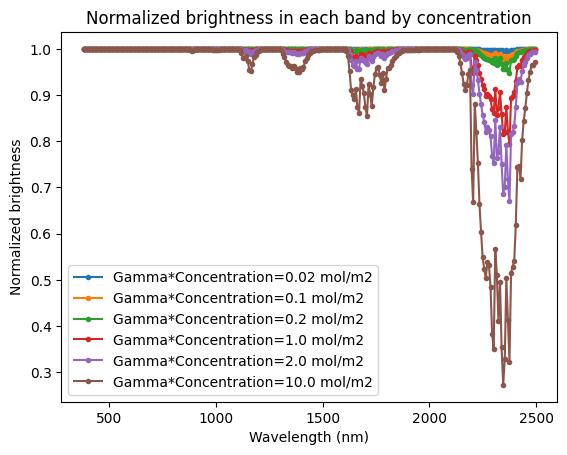

In [23]:
CH4_absorption_da = prepare_absorption_data(hapi_data_path)

# Precompute brightness lookup table
log_normalized_brightness = precompute_log_norm_brightness(
    sensor_band_parameters=sensor_band_parameters,
    CH4_absorption=CH4_absorption_da,
    gamma_concentration=2 * np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0]),
)


# Plot normalized brightness for multiple concentrations
for gc in log_normalized_brightness.gamma_concentration:
    plt.plot(
        sensor_band_parameters["wavelengths"],
        np.exp(log_normalized_brightness.sel(gamma_concentration=gc)),
        ".-",
        label=f"Gamma*Concentration={gc.item()} mol/m2",
    )
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized brightness")
plt.title("Normalized brightness in each band by concentration")
plt.legend()

Text(0.5, 1.0, 'Absorption percentage in band 261')

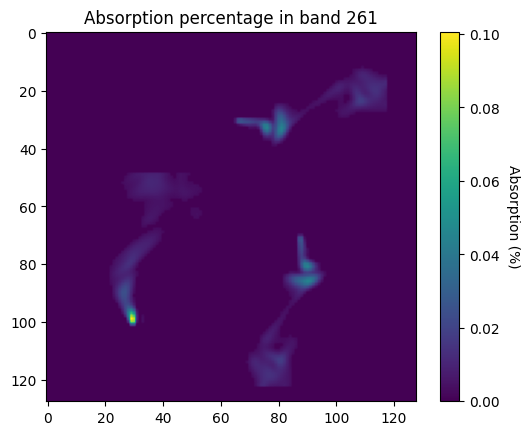

In [24]:
# Plot difference between original and modified radiance as percentage
im = plt.imshow(1 - test_data_item.crop_main[..., 261] / test_data_item.orig_bands[..., 261])
cbar = plt.colorbar(im)
cbar.set_label("Absorption (%)", rotation=270, labelpad=15)  # More control over label position
plt.title("Absorption percentage in band 261")

## Step 4: Save Parquet File for the given EMIT Tile

In [25]:
def write_parquet_file(
    data_items: Iterable[BasePlumesDataItem],
    out_file_path: PurePosixPath,
    storage_options: dict | None = None,
) -> None:
    """Create a single parquet file for the given tile-date-transformation."""
    if storage_options is None:
        storage_options = {}

    data_df = pd.DataFrame(map(lambda item: item.to_dict(), data_items))
    if not data_df.empty:
        data_df.to_parquet(
            str(out_file_path),
            compression="zstd",
            compression_level=9,
            row_group_size=10,
            storage_options=storage_options,
        )
        logging.info(f"Parquet file with {len(data_df)} rows written to {out_file_path}")
    else:
        logging.info("The DataFrame is empty. No Parquet file created.")


def main(
    emit_tile_id: str,
    out_dir: PurePosixPath,
    crop_size: int,
    max_plume_count: int,
    cloud_coverage_threshold: tuple[float, float],
    random_seed: int,
    hapi_data_path: str,
    emit_mask_labels: list[EMITL2AMaskLabel],
    ml_client: MLClient,
    test: bool = False,
    storage_options: dict | None = None,
) -> None:
    """
    Generate synthetic EMIT data with methane plumes and save to parquet.

    Steps:
    1. Download EMIT data
    2. Load plumes
    3. Generate synthetic data items
    4. Save to parquet
    """
    if storage_options is None:
        storage_options = {}

    # Set up random number generator
    rng = np.random.default_rng(random_seed)

    # Step 1: Retrieve EMIT data and hold in memory
    emit_data = download_emit_data(emit_tile_id)

    # Step 2: Load plumes

    # NOTE: How we load in plumes will change depending on where our plume set comes from.
    # As a placeholder, using Gorroño plumes as done in `EMIT-radtran.ipynb`
    # TODO: Replace with actual plume loading from catalog like in `generate.py`
    raw_enhancements = load_gorrono_plumes(ml_client)
    plumes = crop_enhancements(raw_enhancements)

    # Step 3: Generate synthetic data items
    data_items = generate_emit_data_items_from_tile(
        emit_tile_id=emit_tile_id,
        emit_data=emit_data,
        crop_size=crop_size,
        emit_mask_labels=emit_mask_labels,
        main_crop_cloud_coverage_threshold_range=cloud_coverage_threshold,
        hapi_data_path=hapi_data_path,
        plumes=plumes,
        rng=rng,
        max_plume_count=max_plume_count,
        test=test,
    )

    # Step 4: Save to parquet
    write_parquet_file(
        data_items,
        out_dir / f"{emit_tile_id}.parquet",
        storage_options=storage_options,
    )

In [26]:
ml_client = initialize_ml_client()
abfs_out_dir = get_abfs_output_directory(ml_client, "data/emit/test/")
storage_options = get_storage_options(ml_client)

# Set up parameters
emit_tile_id = "EMIT_L1B_RAD_001_20240127T195840_2402713_006"
emit_mask_labels = [
    EMITL2AMaskLabel.CLOUD,
    EMITL2AMaskLabel.CIRRUS_CLOUD,
    EMITL2AMaskLabel.DILATED_CLOUD,
]
hapi_data_path = "../../radtran/data/hapi_data"

main(
    emit_tile_id=emit_tile_id,
    out_dir=abfs_out_dir,
    crop_size=128,
    max_plume_count=5,
    cloud_coverage_threshold=(0.0, 0.3),
    random_seed=42,
    hapi_data_path=hapi_data_path,
    emit_mask_labels=emit_mask_labels,
    ml_client=ml_client,
    test=False,
    storage_options=storage_options,
)

Found the config file in: /config.json


{'rad': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20240127T195840_2402713_006/EMIT_L1B_RAD_001_20240127T195840_2402713_006.nc', 'obs': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20240127T195840_2402713_006/EMIT_L1B_OBS_001_20240127T195840_2402713_006.nc', 'mask': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240127T195840_2402713_006/EMIT_L2A_MASK_001_20240127T195840_2402713_006.nc'}
gorrono_plumes_uri: azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/orbio-data/methane_enhancements_molpercm2


100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.77s/it]


enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 552.45it/s]
2024-12-10 23:47:51,370 - INFO - Biggest reduction factor: 0.8350


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 568.12it/s]
2024-12-10 23:47:52,141 - INFO - Biggest reduction factor: 0.8350


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 528.81it/s]
2024-12-10 23:47:52,946 - INFO - Biggest reduction factor: 0.7608


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 563.80it/s]
2024-12-10 23:47:53,706 - INFO - Biggest reduction factor: 0.8350


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 566.44it/s]
2024-12-10 23:47:54,473 - INFO - Biggest reduction factor: 0.7606


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 547.56it/s]
2024-12-10 23:47:55,251 - INFO - Biggest reduction factor: 0.8348


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 563.10it/s]
2024-12-10 23:47:56,004 - INFO - Biggest reduction factor: 0.8348


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 560.17it/s]
2024-12-10 23:47:56,715 - INFO - Biggest reduction factor: 0.7603


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 561.40it/s]
2024-12-10 23:47:57,578 - INFO - Biggest reduction factor: 0.9316


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 557.29it/s]
2024-12-10 23:47:58,484 - INFO - Biggest reduction factor: 0.7606


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 508.70it/s]
2024-12-10 23:47:59,353 - INFO - Biggest reduction factor: 0.7606


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 453.57it/s]
2024-12-10 23:48:00,768 - INFO - Biggest reduction factor: 0.7606


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 553.77it/s]
2024-12-10 23:48:01,753 - INFO - Biggest reduction factor: 0.8349


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 559.49it/s]
2024-12-10 23:48:02,554 - INFO - Biggest reduction factor: 0.7605


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 536.90it/s]
2024-12-10 23:48:03,391 - INFO - Biggest reduction factor: 0.7604


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 553.61it/s]
2024-12-10 23:48:04,202 - INFO - Biggest reduction factor: 0.8345


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 547.02it/s]
2024-12-10 23:48:04,964 - INFO - Biggest reduction factor: 0.7602


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 552.30it/s]
2024-12-10 23:48:05,983 - INFO - Biggest reduction factor: 0.7598


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 558.14it/s]
2024-12-10 23:48:06,849 - INFO - Biggest reduction factor: 0.9217


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 523.22it/s]
2024-12-10 23:48:07,728 - INFO - Biggest reduction factor: 0.9318


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 550.63it/s]
2024-12-10 23:48:08,770 - INFO - Biggest reduction factor: 0.8347


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 516.80it/s]
2024-12-10 23:48:09,832 - INFO - Biggest reduction factor: 0.7603


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 556.89it/s]
2024-12-10 23:48:10,666 - INFO - Biggest reduction factor: 0.7603


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 554.03it/s]
2024-12-10 23:48:11,597 - INFO - Biggest reduction factor: 0.9317


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 566.01it/s]
2024-12-10 23:48:12,588 - INFO - Biggest reduction factor: 0.9316


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 554.46it/s]
2024-12-10 23:48:13,454 - INFO - Biggest reduction factor: 0.8342


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 555.29it/s]
2024-12-10 23:48:14,383 - INFO - Biggest reduction factor: 0.8347


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 558.54it/s]
2024-12-10 23:48:15,291 - INFO - Biggest reduction factor: 0.8347


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 523.71it/s]
2024-12-10 23:48:16,353 - INFO - Biggest reduction factor: 0.8346


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 563.27it/s]
2024-12-10 23:48:17,344 - INFO - Biggest reduction factor: 0.9298


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 509.59it/s]
2024-12-10 23:48:18,300 - INFO - Biggest reduction factor: 0.7601


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 559.76it/s]
2024-12-10 23:48:19,282 - INFO - Biggest reduction factor: 0.8343


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 537.83it/s]
2024-12-10 23:48:20,179 - INFO - Biggest reduction factor: 0.9214


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 560.11it/s]
2024-12-10 23:48:21,088 - INFO - Biggest reduction factor: 0.7597


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 569.44it/s]
2024-12-10 23:48:22,038 - INFO - Biggest reduction factor: 0.9317


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 563.27it/s]
2024-12-10 23:48:22,905 - INFO - Biggest reduction factor: 0.9298


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 552.21it/s]
2024-12-10 23:48:23,912 - INFO - Biggest reduction factor: 0.7602


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 565.79it/s]
2024-12-10 23:48:24,924 - INFO - Biggest reduction factor: 0.9317


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 562.83it/s]
2024-12-10 23:48:25,776 - INFO - Biggest reduction factor: 0.7601


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 524.61it/s]
2024-12-10 23:48:26,727 - INFO - Biggest reduction factor: 0.8344


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 562.60it/s]
2024-12-10 23:48:27,569 - INFO - Biggest reduction factor: 0.9214


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 552.08it/s]
2024-12-10 23:48:28,522 - INFO - Biggest reduction factor: 0.9296


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 546.61it/s]
2024-12-10 23:48:29,450 - INFO - Biggest reduction factor: 0.8339


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 559.98it/s]
2024-12-10 23:48:30,447 - INFO - Biggest reduction factor: 0.7600


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 560.36it/s]
2024-12-10 23:48:31,398 - INFO - Biggest reduction factor: 0.9215


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 559.70it/s]
2024-12-10 23:48:32,272 - INFO - Biggest reduction factor: 0.8344


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 529.93it/s]
2024-12-10 23:48:33,185 - INFO - Biggest reduction factor: 0.9215


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 562.30it/s]
2024-12-10 23:48:34,082 - INFO - Biggest reduction factor: 0.7600


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 543.04it/s]
2024-12-10 23:48:34,947 - INFO - Biggest reduction factor: 0.9214


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 561.62it/s]
2024-12-10 23:48:35,812 - INFO - Biggest reduction factor: 0.7597


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 558.54it/s]
2024-12-10 23:48:36,727 - INFO - Biggest reduction factor: 0.7596


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 556.04it/s]
2024-12-10 23:48:37,657 - INFO - Biggest reduction factor: 0.9212


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 553.19it/s]
2024-12-10 23:48:38,564 - INFO - Biggest reduction factor: 0.7599


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 522.89it/s]
2024-12-10 23:48:39,505 - INFO - Biggest reduction factor: 0.8343


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 558.91it/s]
2024-12-10 23:48:40,465 - INFO - Biggest reduction factor: 0.8343


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 523.74it/s]
2024-12-10 23:48:41,420 - INFO - Biggest reduction factor: 0.8343


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 559.64it/s]
2024-12-10 23:48:42,373 - INFO - Biggest reduction factor: 0.8342


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 536.98it/s]
2024-12-10 23:48:43,293 - INFO - Biggest reduction factor: 0.9296


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 551.89it/s]
2024-12-10 23:48:44,194 - INFO - Biggest reduction factor: 0.8340


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 553.48it/s]
2024-12-10 23:48:45,256 - INFO - Biggest reduction factor: 0.8339


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 562.88it/s]
2024-12-10 23:48:46,196 - INFO - Biggest reduction factor: 0.7592


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 565.84it/s]
2024-12-10 23:48:47,136 - INFO - Biggest reduction factor: 0.7598


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 543.90it/s]
2024-12-10 23:48:48,044 - INFO - Biggest reduction factor: 0.7598


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 562.94it/s]
2024-12-10 23:48:48,941 - INFO - Biggest reduction factor: 0.7598


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 508.26it/s]
2024-12-10 23:48:49,879 - INFO - Biggest reduction factor: 0.8341


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 558.82it/s]
2024-12-10 23:48:50,786 - INFO - Biggest reduction factor: 0.7596


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 527.51it/s]
2024-12-10 23:48:51,852 - INFO - Biggest reduction factor: 0.8341


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 548.20it/s]
2024-12-10 23:48:52,807 - INFO - Biggest reduction factor: 0.8339


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 549.59it/s]
2024-12-10 23:48:53,661 - INFO - Biggest reduction factor: 0.8338


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 533.75it/s]
2024-12-10 23:48:54,621 - INFO - Biggest reduction factor: 0.8336


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 549.13it/s]
2024-12-10 23:48:55,433 - INFO - Biggest reduction factor: 0.7597


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 510.76it/s]
2024-12-10 23:48:56,358 - INFO - Biggest reduction factor: 0.7596


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 568.79it/s]
2024-12-10 23:48:57,251 - INFO - Biggest reduction factor: 0.8341


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 523.72it/s]
2024-12-10 23:48:58,159 - INFO - Biggest reduction factor: 0.8340


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 562.34it/s]
2024-12-10 23:48:59,187 - INFO - Biggest reduction factor: 0.8340


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 538.99it/s]
2024-12-10 23:49:00,119 - INFO - Biggest reduction factor: 0.7594


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 555.16it/s]
2024-12-10 23:49:01,155 - INFO - Biggest reduction factor: 0.7593


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 575.32it/s]
2024-12-10 23:49:02,112 - INFO - Biggest reduction factor: 0.9211


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 564.62it/s]
2024-12-10 23:49:03,084 - INFO - Biggest reduction factor: 0.7595


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 558.55it/s]
2024-12-10 23:49:03,976 - INFO - Biggest reduction factor: 0.9212


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 517.53it/s]
2024-12-10 23:49:04,850 - INFO - Biggest reduction factor: 0.8340


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 556.35it/s]
2024-12-10 23:49:05,846 - INFO - Biggest reduction factor: 0.8339


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 516.94it/s]
2024-12-10 23:49:06,778 - INFO - Biggest reduction factor: 0.9295


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 556.91it/s]
2024-12-10 23:49:07,654 - INFO - Biggest reduction factor: 0.7592


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 546.82it/s]
2024-12-10 23:49:08,502 - INFO - Biggest reduction factor: 0.8336


rad_crop: float32
modified_rad_crop: float32
enhancement_da: float64


100%|█████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 561.53it/s]
2024-12-10 23:49:09,413 - INFO - Biggest reduction factor: 0.8332


rad_crop: float32
modified_rad_crop: float32


2024-12-10 23:50:44,244 - INFO - Parquet file with 86 rows written to abfs://azureml-blobstore-23d8394c-3e7f-44e2-bbca-6906690a5f6d/data/emit/test/EMIT_L1B_RAD_001_20240127T195840_2402713_006.parquet


#### Check parquet file

Found the config file in: /config.json


Text(0.5, 1.0, 'Absorption percentage in band 261')

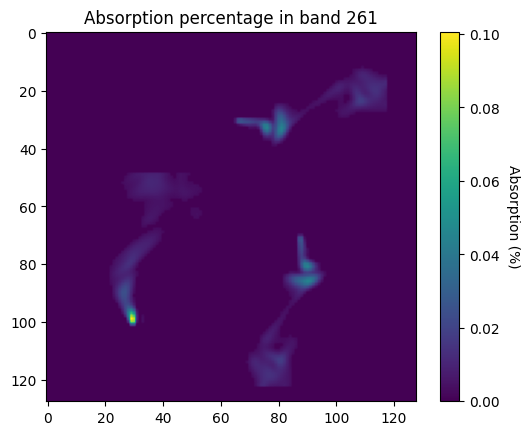

In [27]:
import pandas as pd
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())

uri = "azureml://subscriptions/6e71ce37-b9fe-4c43-942b-cf0f7e78c8ab/resourcegroups/orbio-ml-rg/workspaces/orbio-ml-ml-workspace/datastores/workspaceblobstore/paths/data/emit/test/EMIT_L1B_RAD_001_20240127T195840_2402713_006.parquet"

df = pd.read_parquet(uri)

test_row = df.iloc[0]
crop_main = np.frombuffer(test_row["crop_main"], dtype=np.float32).reshape(128, 128, 285)
orig_bands = np.frombuffer(test_row["orig_bands"], dtype=np.float32).reshape(128, 128, 285)

# Calculate absorption percentage for band 261
band_idx = 261
absorption = 1 - crop_main[..., band_idx] / orig_bands[..., band_idx]

# Create the plot
im = plt.imshow(absorption)
cbar = plt.colorbar(im)
cbar.set_label("Absorption (%)", rotation=270, labelpad=15)
plt.title("Absorption percentage in band 261")

Same plot as above ✅

In [28]:
len(df)

86